<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/04_04_gan_dcgan_mnist_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 4-4 : DCGAN with MNIST** 

## **Import Module**

In [0]:
%tensorflow_version 1.x


In [0]:
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Input,Dense,Reshape
from tensorflow.keras.layers import ReLU,LeakyReLU,Dropout,Flatten
from tensorflow.keras.layers import Conv2DTranspose,Conv2D,BatchNormalization
from tensorflow.keras.datasets import mnist

import numpy as np

## **DataSet**

### Load

In [0]:
# X_train만 사용
(X_train, _), (_, _) = mnist.load_data() 

### Preprocessing

In [0]:
# Generator의 마지막 활성화 함수를 "tanh(.)"를 사용했기 때문에(by 권고), (-1 ~ 1) 로 스케일링 해준다.
X_train = X_train.astype(np.float32) / 127.5 - 1 
X_train = np.expand_dims(X_train, axis=-1) #(28,28,1)

## **Model**

### Function define for saving model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/Shared drives/scsa_2019_c/07_kyn/models/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def save_models(title, epoch):
    generator.save(save_path+"dcgan_generator_{}_{}.hdf5".format(title, epoch))
    discriminator.save(save_path+"dcgan_discriminator_{}_{}.hdf5".format(title, epoch))
    gan.save(save_path+"dcgan_combined_{}_{}.hdf5".format(title, epoch))



In [0]:
def load_models(title, epoch):
  gen = load_model(save_path+"dcgan_generator_{}_{}.hdf5".format(title, epoch))
  dis = load_model(save_path+"dcgan_discriminator_{}_{}.hdf5".format(title, epoch))
  g = load_model(save_path+"dcgan_combined_{}_{}.hdf5".format(title, epoch))
  return gen, dis, g


In [0]:
train_model = True      # T: training
#train_model = False     # F: loading

### model params

In [0]:
latent_dim = 100
height = 28
width = 28
channels = 1

### Define generator

In [0]:
generator_input = keras.Input(shape=(latent_dim,))
x = Dense(128 * 7 * 7)(generator_input) #(6272)
x = Reshape((7, 7, 128))(x)
x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)#(14,14,128)
x = Conv2D(128, 4, padding='same')(x)                    #( ''      )
x = BatchNormalization(momentum=0.8)(x) #default=0.99
x = ReLU()(x)
x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)#(28,28,128)
x = Conv2D(64, 4, padding='same')(x)                     #(28,28,64)
x = BatchNormalization(momentum=0.8)(x)
x = ReLU()(x)
x = Conv2D(channels, 7, activation='tanh', padding='same')(x)#(28,28,1)

generator = Model(generator_input, x)
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
______________________________________________

### Define discriminator

In [0]:
discriminator_input = Input(shape=(height, width, channels))#(28,28,1)
x = Conv2D(32, 3, strides=2, padding='same')(discriminator_input)#(14,14,32)
x = LeakyReLU(alpha=0.2)(x) #leakyReLU
x = Dropout(0.2)(x)
x = Conv2D(64, 4, strides=2, padding='same')(x)     #(7,7,64)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)
x = Conv2D(128, 4, strides=2, padding='same')(x)    #(4,4,128)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Conv2D(256, 4, strides=1, padding='same')(x)    #(4,4,256)
x = BatchNormalization(momentum=0.8)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)    #(4096)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)


discriminator_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
                              # discriminator_optimizer라고 따로 지정해준 이유는, 바로 위에서 learning rate 등을 조절하면서 훈련시킬 수 있게끔 하기 위함!
discriminator.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_______________________________

### Define GAN model 

In [0]:
gan_input = Input(shape=(latent_dim,))

# discriminator는 학습 하지 않도록 설정 
discriminator.trainable = False ##
gan_output = discriminator(generator(gan_input)) # D(G(z))
gan = Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### Fit function

In [0]:
batch_size = 32

def train(epochs, print_step=100):
    history = []
    for epoch in range(epochs):

        # 실제 이미지 Batch 추출
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        real_label = np.ones((batch_size, 1)) # ones
        
        # 이미지 생성
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_images = generator.predict(noise)
        fake_label = np.zeros((batch_size, 1)) # zeros
        
        # label에 Noise 추가 
        real_label += 0.05 * np.random.normal(0, 1, size=real_label.shape)
        fake_label += 0.05 * np.random.normal(0, 1, size=fake_label.shape)
        
        # discriminator 학습 (train_on_batch)
        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_label)  #  --> 내가 fake를 주지만, 진짜라고 말하고 D-model에 넣어줌!
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # generator 학습 (train_on_batch) ## GAN model
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # 기록
        record = (epoch, d_loss[0], g_loss[0])
        history.append(record)

        if epoch % print_step == 0:
            print("%5d D loss: %.3f, G loss: %.3f" % record)
        
    return history

### Fit 500

CPU times: user 33.5 s, sys: 8.99 s, total: 42.5 s   
Wall time: 46.1 s (@500)

In [0]:
%%time
if train_model == True:
  history500 = train(500, 10)
  save_models("mnist", 500)
else:
  generator, _, _ = load_models("mnist",500)


    0 D loss: 1.144, G loss: 1.524
   10 D loss: 0.743, G loss: 1.408
   20 D loss: 0.087, G loss: 0.187
   30 D loss: 0.429, G loss: 1.696
   40 D loss: 0.753, G loss: 3.214
   50 D loss: 0.133, G loss: 3.936
   60 D loss: 1.458, G loss: 2.132
   70 D loss: 1.241, G loss: 1.828
   80 D loss: 1.083, G loss: 1.697
   90 D loss: 0.945, G loss: 1.224
  100 D loss: 0.756, G loss: 1.680
  110 D loss: 0.956, G loss: 1.400
  120 D loss: 1.264, G loss: 1.170
  130 D loss: 0.977, G loss: 1.183
  140 D loss: 0.709, G loss: 1.394
  150 D loss: 0.749, G loss: 1.522
  160 D loss: 0.993, G loss: 1.469
  170 D loss: 0.935, G loss: 1.176
  180 D loss: 0.945, G loss: 1.004
  190 D loss: 0.939, G loss: 0.969
  200 D loss: 1.086, G loss: 1.029
  210 D loss: 0.787, G loss: 1.068
  220 D loss: 0.769, G loss: 1.282
  230 D loss: 0.848, G loss: 1.062
  240 D loss: 0.868, G loss: 1.055
  250 D loss: 0.820, G loss: 1.090
  260 D loss: 0.712, G loss: 1.018
  270 D loss: 0.880, G loss: 1.081
  280 D loss: 0.802,

>#### Plot 500

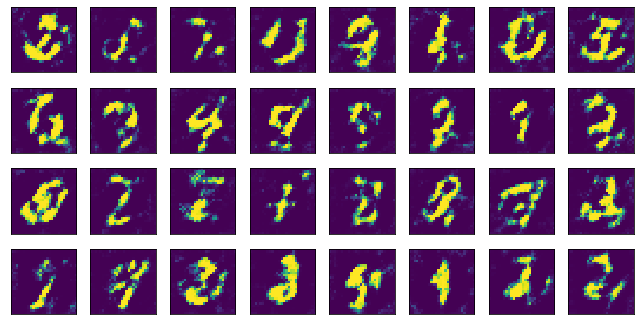

In [0]:
import matplotlib.pyplot as plt

def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    fig = plt.figure(figsize=figsize)
    plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(n):
        for j in range(m):
            k = i * m + j
            ax = fig.add_subplot(n, m, i * m + j + 1)
            ax.imshow(generated_images[k][:, :, 0])#, cmap=plt.cm.bone)
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.show()


noise_data = np.random.normal(0, 1, size=(32, latent_dim))
show_images(0.5 * generator.predict(noise_data) + 0.5) #Generator Af='tanh'

### Fit 4500

CPU times: user 4min 17s, sys: 1min 15s, total: 5min 32s   
Wall time: 5min 42s

In [0]:
%%time
if train_model == True:
  history500 = train(4500, 100)
  save_models("mnist", 4500)
else:
  generator, _, _ = load_models("mnist",4500)


    0 D loss: 0.715, G loss: 1.056
  100 D loss: 0.624, G loss: 1.204
  200 D loss: 0.638, G loss: 1.089
  300 D loss: 0.734, G loss: 0.932
  400 D loss: 0.742, G loss: 1.126
  500 D loss: 0.657, G loss: 1.153
  600 D loss: 0.712, G loss: 0.901
  700 D loss: 0.676, G loss: 1.159
  800 D loss: 0.750, G loss: 1.116
  900 D loss: 0.673, G loss: 0.946
 1000 D loss: 0.703, G loss: 1.028
 1100 D loss: 0.818, G loss: 0.913
 1200 D loss: 0.703, G loss: 1.091
 1300 D loss: 0.684, G loss: 1.092
 1400 D loss: 0.718, G loss: 0.976
 1500 D loss: 0.615, G loss: 1.049
 1600 D loss: 0.821, G loss: 1.087
 1700 D loss: 0.730, G loss: 1.072
 1800 D loss: 0.598, G loss: 1.182
 1900 D loss: 0.747, G loss: 1.062
 2000 D loss: 0.735, G loss: 1.075
 2100 D loss: 0.736, G loss: 0.942
 2200 D loss: 0.729, G loss: 1.157
 2300 D loss: 0.625, G loss: 1.193
 2400 D loss: 0.651, G loss: 0.956
 2500 D loss: 0.446, G loss: 1.617
 2600 D loss: 0.563, G loss: 1.207
 2700 D loss: 0.493, G loss: 1.327
 2800 D loss: 0.556,

>#### Plot 4500

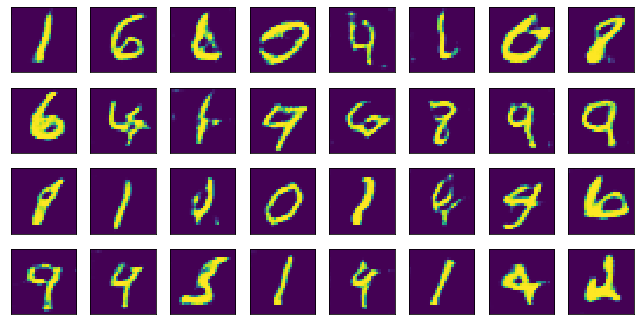

In [0]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

### Fit 15000

CPU times: user 14min 11s, sys: 4min 10s, total: 18min 21s   
Wall time: 18min 56s (@15000)

In [0]:
%%time
if train_model == True:
  history15000 = train(15000, 500)
  save_models("mnist", 15000)
else:
  generator, _, _ = load_models("mnist",15000)



    0 D loss: 0.455, G loss: 1.436
  500 D loss: 0.516, G loss: 2.420
 1000 D loss: 0.705, G loss: 1.311
 1500 D loss: 0.539, G loss: 1.498
 2000 D loss: 0.346, G loss: 1.811
 2500 D loss: 0.368, G loss: 1.908
 3000 D loss: 0.245, G loss: 2.463
 3500 D loss: 0.608, G loss: 1.605
 4000 D loss: 0.317, G loss: 1.558
 4500 D loss: 0.480, G loss: 1.958
 5000 D loss: 1.241, G loss: 0.975
 5500 D loss: 0.163, G loss: 2.563
 6000 D loss: 0.564, G loss: 2.979
 6500 D loss: 0.259, G loss: 2.059
 7000 D loss: 0.476, G loss: 2.078
 7500 D loss: 0.523, G loss: 2.005
 8000 D loss: 0.349, G loss: 1.001
 8500 D loss: 0.509, G loss: 2.067
 9000 D loss: 0.299, G loss: 1.991
 9500 D loss: 0.406, G loss: 1.459
10000 D loss: 0.216, G loss: 2.784
10500 D loss: 0.600, G loss: 1.661
11000 D loss: 0.294, G loss: 2.143
11500 D loss: 0.216, G loss: 2.329
12000 D loss: 0.521, G loss: 1.268
12500 D loss: 1.088, G loss: 2.238
13000 D loss: 0.221, G loss: 2.727
13500 D loss: 0.458, G loss: 1.765
14000 D loss: 0.532,

>#### Plot 15000

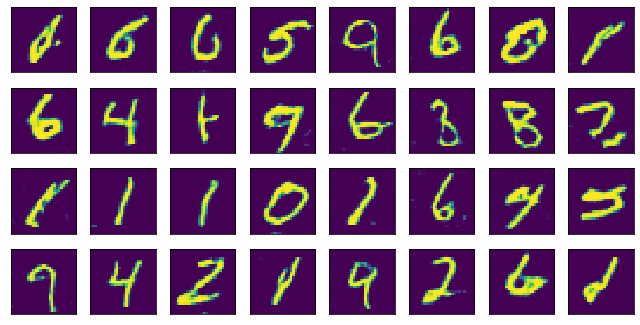

In [0]:
show_images(0.5 * generator.predict(noise_data) + 0.5)

CPU times: user 13min 18s, sys: 3min 53s, total: 17min 11s  
Wall time: 18min 9s  

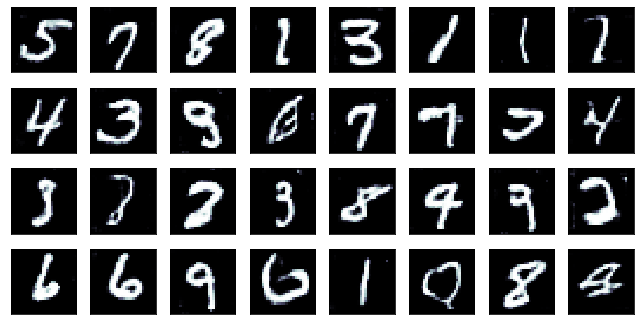

In [0]:
save_models("mnist", 20000)